## Inference
    What I want to do is show how inference for the current models I have. The spatial net is about 59% accuracy and the temporal net is  at about 25% accuracy. Note, this is for a 101 different classes. So this is way better than taking a guess. The current state of the art is 95% accuracy combined. The tech that this notebook uses achieved 72% for the spatial net and 81% for the temporal net. 
    
### Methodology
    The way in which we aim to do inference. Is simply by accumulating inference on all images in a video and normalising this for all classes. We aim to do this for both spatial (rgb images) and temporal (optical flow) net.
    

In [2]:
# lets load up the models

# spatial net 

import os
import sys

up1 = os.path.abspath('..') 
sys.path.insert(0, up1)

In [83]:
from keras_data_generator.ucf101_datagenerator.generator_class import DataGenerator as SpatialDataGenerator
from keras_data_generator.ucf101_datagenerator.optical_flow_data_gen import DataGenerator as OpticalFlowDataGenerator
from ucf101_data_utils import get_test_data, get_train_data
from keras.optimizers import SGD
# quick check the generators are working
from matplotlib import pyplot as plt


In [84]:
from network import getVggModel

In [85]:
spatial_model=getVggModel((224,224,3), printmod=0)
spatial_model.load_weights('.spatial_model_weights2.hdf5')

In [24]:
# Parameters
params = { 'data_dir' : "/data",
          'dim': (224,224),
          'batch_size': 32,
          'n_classes': 101,
          'n_channels': 3,
          'shuffle': True,
        'validation' : True}

id_labels_test = get_test_data('../keras_data_generator/ucf101_splits/testlist01.txt',
                              '../keras_data_generator/ucf101_splits/classInd.txt')

spatial_validation_generator = SpatialDataGenerator(*id_labels_test, **params)

In [20]:
id_labels_test[1]['v_HandstandPushups_g01_c01']

37

In [21]:
v = [ 'v_BaseballPitch_g06_c01', 'v_CricketShot_g04_c02', 'v_BrushingTeeth_g05_c01', 'v_Drumming_g01_c01', \
    'v_HeadMassage_g03_c07']

In [202]:
(X, y) = spatial_validation_generator.get_all_frames_for_video_id(v[4])

In [203]:
X.shape

(337, 224, 224, 3)

In [204]:
y

38

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


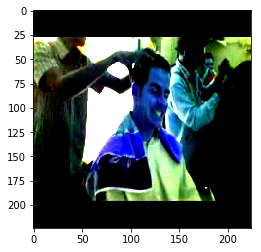

In [205]:
plt.imshow(X[31,:,:,:])

In [206]:
prediction = model.predict(X[12,].reshape(1,224,224,3))

In [207]:
X.shape

(337, 224, 224, 3)

In [208]:
index = prediction.argsort()
index = index[0]

print(index[-1:-6:-1])
print(prediction[0,index[-1:-6:-1]])

[38 33 12 13  0]
[0.43916246 0.25747174 0.16451545 0.0511774  0.03536236]


In [209]:
prediction = model.predict(X[0:50])
    

In [210]:
import  numpy as np

In [211]:
prediction.shape

(50, 101)

In [212]:
prediction_mean = prediction.mean(axis=0)

In [213]:
prediction_mean =prediction_mean.reshape((1,101))

In [214]:
y

38

In [215]:
index = prediction_mean.argsort(axis=1)
index = index[0]

print(index[-1:-6:-1])
print(prediction_mean[0,index[-1:-6:-1]])

[33 12 38  0 77]
[0.32336396 0.18613559 0.17083357 0.09973328 0.08042434]


# Temporal 

In [29]:
from network import getSimpleMotionModelOnly, getKerasCifarMotionModelOnly

In [30]:
motion_model = getKerasCifarMotionModelOnly(input_shape=(224,224,2), n_classes=101, printmod=0)

In [31]:
params = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : True}


import re 
import csv

def get_train_data(listPath):
# load Id list and labels 

    train_list = list()

    with open(listPath, 'r') as f:
        reader = csv.reader(f)
        train_list = list(reader)

    labels = [int(label[0].split(' ')[1]) for label in train_list ]
    IDs = [label[0].split(' ')[0] for label in train_list ]
    # IDs
    IDs = [id.split('/')[1].rstrip('.avi') for id in IDs ]

    labels = dict(zip(IDs, labels))
    return (IDs, labels)

def get_test_data(listPath, classIndexPath):
# load Id list and labels 
    
    train_list = None
    class_labels = None
    with open(listPath, 'r') as f:
        reader = csv.reader(f)
        train_list = list(reader)

    with open(classIndexPath, 'r') as f:
        reader = csv.reader(f)
        class_labels = list(reader)
    
    ucf_class = [c[0].split(' ')[1] for c in class_labels]
    ucf_labels = [int(c[0].split(' ')[0]) for c in class_labels]
    
    ucf_dict = dict(zip(ucf_class, ucf_labels))
    
    IDs = [id_[0].split('/')[1].rstrip('.avi') for id_ in train_list ]
    labels = dict()
    
    p = re.compile('v\_([a-zA-Z]*)\_g\w*') 
    for id_ in IDs:
        f = p.match(id_)
        if f:
            labels[id_] = ucf_dict[f[1]]
        else:
            Exception("failed")
    return IDs, labels

id_test = get_test_data('../keras_data_generator/ucf101_splits/testlist01.txt', \
                       '../keras_data_generator/ucf101_splits/classInd.txt')

motion_validation_generator = OpticalFlowDataGenerator(id_test[0], id_test[1], **params)


In [33]:
motion_model.load_weights('.motion_model_cifar_weights3.h5')

In [225]:
(X_opt, y_opt) = motion_validation_generator.get_all_frames_for_video_id(v[4], 10)

In [226]:
X_opt.shape

(10, 224, 224, 2)

In [227]:
y_opt

38

In [228]:
prediction = motion_model.predict(X_opt)

In [229]:
prediction_mean = prediction.mean(axis=0)
prediction_mean =prediction_mean.reshape((1,101))
index = prediction_mean.argsort(axis=1)
index = index[0]
print(index[-1:-10:-1])
print(prediction_mean[0,index[-1:-10:-1]])

[82 38 33  3 16 12 21 51 13]
[0.1832947  0.12482084 0.05246019 0.03359877 0.0311608  0.02759217
 0.02522077 0.02514945 0.02465636]


## Add Labels

    

In [13]:
labels_list = list()

with open('/data/su_buildup/su_buildup/keras_data_generator/ucf101_splits/classInd.txt', 'r') as f:
    reader = csv.reader(f)
    labels_list = list(reader)

labels = [int(label[0].split(' ')[0]) for label in train_list ]
IDs = [label[0].split(' ')[1] for label in train_list ]


labels_dict = dict(zip(labels, IDs))

In [86]:
v = [ 'v_BaseballPitch_g06_c01', 'v_CricketShot_g04_c02', 'v_BrushingTeeth_g05_c01', 'v_Drumming_g01_c01', \
    'v_HeadMassage_g03_c07', 'v_ApplyLipstick_g01_c03']

In [87]:
baseball = v[0]

In [88]:
(X, y) = spatial_validation_generator.get_all_frames_for_video_id(baseball)
(X_opt, y_opt) = motion_validation_generator.get_all_frames_for_video_id(baseball, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


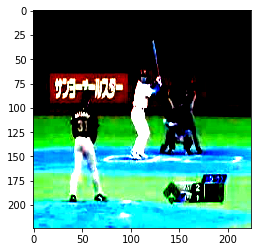

In [93]:
plt.imshow(X[3])

In [94]:
spatial_prediction = spatial_model.predict(X[0:50])
temporal_prediction = motion_model.predict(X_opt[0:50])



In [42]:
spatial_prediction.shape

(50, 101)

In [96]:
spatial_prediction_mean = spatial_prediction.mean(axis=0)
spatial_prediction_mean =spatial_prediction_mean.reshape((1,101))
spatial_index = spatial_prediction_mean.argsort(axis=1)
spatial_index = spatial_index[0]

temporal_prediction_mean = temporal_prediction.mean(axis=0)
temporal_prediction_mean =temporal_prediction_mean.reshape((1,101))
temporal_index = temporal_prediction_mean.argsort(axis=1)
temporal_index = temporal_index[0]

print("Spatial Ranking\n")

for i, ID in enumerate(spatial_index[-1:-6:-1]):
    print(i+1, labels_dict[ID+1], ", ",spatial_prediction_mean[0,ID])
    
    
print("\n\nTemporal Ranking\n")

for i, ID in enumerate(temporal_index[-1:-15:-1]):
    print(i+1, labels_dict[ID+1], ", ", temporal_prediction_mean[0,ID])
    

Spatial Ranking

1 BaseballPitch ,  0.9791858
2 Skiing ,  0.007579
3 Skijet ,  0.0032485789
4 JugglingBalls ,  0.001303896
5 CliffDiving ,  0.0010185129


Temporal Ranking

1 FrontCrawl ,  0.24702772
2 MilitaryParade ,  0.10257161
3 TrampolineJumping ,  0.10213153
4 BandMarching ,  0.09516511
5 Drumming ,  0.08469337
6 Biking ,  0.06861996
7 Rafting ,  0.0371033
8 Swing ,  0.030166801
9 Kayaking ,  0.02619857
10 HorseRiding ,  0.016400928
11 WalkingWithDog ,  0.014365226
12 JavelinThrow ,  0.0115594175
13 PizzaTossing ,  0.011508147
14 PoleVault ,  0.011322323


## Cut Hair (Medium)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


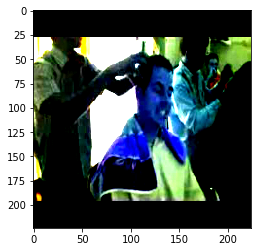

In [97]:
hair_massage = v[4]

(X, y) = spatial_validation_generator.get_all_frames_for_video_id(hair_massage)
(X_opt, y_opt) = motion_validation_generator.get_all_frames_for_video_id(hair_massage, 10)

plt.imshow(X[3,])

In [98]:
spatial_prediction = spatial_model.predict(X[0:50])
temporal_prediction = motion_model.predict(X_opt[0:50])

In [106]:
spatial_prediction_mean = spatial_prediction.mean(axis=0)
spatial_prediction_mean =spatial_prediction_mean.reshape((1,101))
spatial_index = spatial_prediction_mean.argsort(axis=1)
spatial_index = spatial_index[0]

temporal_prediction_mean = temporal_prediction.mean(axis=0)
temporal_prediction_mean =temporal_prediction_mean.reshape((1,101))
temporal_index = temporal_prediction_mean.argsort(axis=1)
temporal_index = temporal_index[0]

print("Spatial Ranking\n")

for i, ID in enumerate(spatial_index[-1:-6:-1]):
    print(i+1, labels_dict[ID+1], ", ",spatial_prediction_mean[0,ID])
    
    
print("\n\nTemporal Ranking\n")

for i, ID in enumerate(temporal_index[-1:-20:-1]):
    print(i+1, labels_dict[ID+1], ", ", temporal_prediction_mean[0,ID])

Spatial Ranking

1 ShavingBeard ,  0.6544574
2 Haircut ,  0.082323484
3 Knitting ,  0.05046214
4 CuttingInKitchen ,  0.04873625
5 PlayingDaf ,  0.029709242


Temporal Ranking

1 ApplyEyeMakeup ,  0.2341609
2 ShavingBeard ,  0.10893796
3 BrushingTeeth ,  0.05496613
4 SkyDiving ,  0.053943854
5 ApplyLipstick ,  0.042468973
6 BlowDryHair ,  0.039992254
7 Knitting ,  0.036871396
8 BoxingPunchingBag ,  0.034031354
9 WritingOnBoard ,  0.028679777
10 HeadMassage ,  0.019432511
11 Haircut ,  0.010879243
12 PlayingSitar ,  0.010498374
13 WallPushups ,  0.010424213
14 PlayingViolin ,  0.0102583235
15 CliffDiving ,  0.009836682
16 PlayingFlute ,  0.009803212
17 Billiards ,  0.0091073
18 TaiChi ,  0.008996398
19 TennisSwing ,  0.0089300405


## Brushing Teeth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


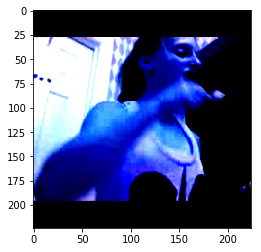

In [103]:
apply_lipstick = v[2]

(X, y) = spatial_validation_generator.get_all_frames_for_video_id(apply_lipstick)
(X_opt, y_opt) = motion_validation_generator.get_all_frames_for_video_id(apply_lipstick, 10)

plt.imshow(X[1,:,:,:])

In [104]:
spatial_prediction = spatial_model.predict(X[0:50])
temporal_prediction = motion_model.predict(X_opt[0:50])

In [75]:
spatial_prediction_mean = spatial_prediction.mean(axis=0)
spatial_prediction_mean =spatial_prediction_mean.reshape((1,101))
spatial_index = spatial_prediction_mean.argsort(axis=1)
spatial_index = spatial_index[0]

temporal_prediction_mean = temporal_prediction.mean(axis=0)
temporal_prediction_mean =temporal_prediction_mean.reshape((1,101))
temporal_index = temporal_prediction_mean.argsort(axis=1)
temporal_index = temporal_index[0]

print("Spatial Ranking\n")

for i, ID in enumerate(spatial_index[-1:-6:-1]):
    print(i+1, labels_dict[ID+1], ", ",spatial_prediction_mean[0,ID])
    
    
print("\n\nTemporal Ranking\n")

for i, ID in enumerate(temporal_index[-1:-6:-1]):
    print(i+1, labels_dict[ID+1], ", ", temporal_prediction_mean[0,ID])

Spatial Ranking

1 ShavingBeard ,  0.6544574
2 Haircut ,  0.082323484
3 Knitting ,  0.05046214
4 CuttingInKitchen ,  0.04873625
5 PlayingDaf ,  0.029709242


Temporal Ranking

1 Knitting ,  0.083242714
2 SkyDiving ,  0.050685875
3 BoxingPunchingBag ,  0.040485706
4 ShavingBeard ,  0.03960353
5 BoxingSpeedBag ,  0.038432762
